In [ ]:
# !conda install numpy pandas matplotlib seaborn scikit-learn missingno category_encoders xgboost -y

In [ ]:
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import missingno as msno

from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split

from sklearn.experimental import enable_iterative_imputer 
from sklearn.impute import IterativeImputer
import category_encoders as ce

from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.metrics import roc_auc_score, classification_report, roc_curve, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import cross_val_predict, cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.feature_selection import SelectFromModel

import joblib
import unittest

#### Loading Data

In [ ]:
data = pd.read_csv('../data/raw/train.data/train.data', sep = '\t')

In [ ]:
data['is_churn'] = pd.read_csv('../data/raw/train_churn.labels.txt', header = None)

# for readability and consitency, lets make labels 0 and 1
data['is_churn'] = data.is_churn.apply(lambda x: 0 if (x == -1) else x) 

### PRE-PROCESSING

In [ ]:
data.drop_duplicates(inplace=True)
data.dropna(how='all',inplace=True)
data = data.loc[:, data.isna().mean() <= 0.6]
joblib.dump(data.columns, '../data/processed/preprocessed_columns.pkl')
data.to_csv('../data/processed/preprocessed.csv')

### Feature Engineering

In [ ]:
# binning var_73 as it showed a multimodal distribution
def bin_variable(df, column,bins,labels):
    df2 = df.copy()
    df2[column] = pd.cut(df2[column], bins=bins, labels=labels)
    return df2
    
def create_category_mapping(df, threshold=0.85, min_sample_size=68):
    
    category_mappings = {}
    def bin_categories(df, column, threshold, min_sample_size):
        counts = df[column].value_counts(dropna=False)
        proportions = counts / len(df[column])
        cumulative_sum = 0
        categories_to_keep = []

        for category, count in counts.items():
            if count < min_sample_size:
                continue
            cumulative_sum += proportions[category]
            categories_to_keep.append(category)
            if cumulative_sum >= threshold:
                break

        if not categories_to_keep:
            categories_to_keep.append(counts.idxmax())

        category_mappings[column] = categories_to_keep

    for column in df.select_dtypes(include=['object']).columns:
        bin_categories(df, column, threshold, min_sample_size)

    return category_mappings
    
def apply_category_mapping(df, category_mappings):
    df_copy = df.copy()
    for column, categories_to_keep in category_mappings.items():
        df_copy[column] = df_copy[column].apply(lambda x: x if x in categories_to_keep else 'Others')
    return df_copy    

def encode_low_cardinality(df, max_value=8):
    df_copy = df.copy()
    categorical_columns = df_copy.select_dtypes(include=['object']).columns
    ohe_mapping = {}
    
    for column in categorical_columns:
        if df_copy[column].nunique() <= max_value:
            one_hot_encoder = OneHotEncoder(sparse=False, drop='first')
            one_hot_encoded = one_hot_encoder.fit_transform(df_copy[[column]])
            one_hot_encoded_df = pd.DataFrame(one_hot_encoded, columns=one_hot_encoder.get_feature_names_out([column]))
            df_copy = pd.concat([df_copy, one_hot_encoded_df], axis=1)
            df_copy.drop(column, axis=1, inplace=True)
            ohe_mapping[column] = one_hot_encoder
    
    return df_copy, ohe_mapping

def flag_numeric(df):
    na_flags = []
    for column_name in df.columns:
        if pd.api.types.is_numeric_dtype(df[column_name]):
            if df[column_name].isna().any():
                df[column_name + '_na'] = df[column_name].isna()
                na_flags.append(column_name + '_na')
    return df, na_flags    
    
def get_duplicate_mapping(df):
    duplicate_features_groups = []
    checked_features = set()

    for i, feature1 in enumerate(df.columns):
        if feature1 not in checked_features:
            duplicates = [feature1]
            for feature2 in df.columns[i + 1:]:
                if feature2 not in checked_features:
                    if df[feature1].nunique(dropna=False) == df[feature2].nunique(dropna=False):
                        if df[feature1].equals(df[feature2]):
                            duplicates.append(feature2)
                        elif df[[feature1, feature2]].drop_duplicates().shape[0] == df[feature1].nunique(dropna=False):
                            duplicates.append(feature2)
            if len(duplicates) > 1:
                duplicate_features_groups.append(duplicates)
                checked_features.update(duplicates)

    return duplicate_features_groups
    
def encode_categorical_with_woe(X_train, X_test, y_train):
    woe_encoder = ce.WOEEncoder(cols=X_train.select_dtypes('O').columns)
    X_train_encoded = X_train.copy()
    X_train_encoded[X_train.select_dtypes('O').columns] = woe_encoder.fit_transform(X_train.select_dtypes('O'), y_train)
    X_test_encoded = X_test.copy()
    X_test_encoded[X_test.select_dtypes('O').columns] = woe_encoder.transform(X_test.select_dtypes('O'))
    return woe_encoder,X_train_encoded, X_test_encoded

def impute_missing_values_iterative(X_train, X_test):
    X_train_imputed,X_test_imputed = X_train, X_test
    imp = IterativeImputer(missing_values=np.nan, random_state=9, n_nearest_features=5, max_iter=10)
    X_train_imputed.loc[:, X_train.columns] = imp.fit_transform(X_train)
    X_test_imputed.loc[:, X_test.columns]=imp.transform(X_test)
    return imp,X_train_imputed, X_test_imputed

In [ ]:
bins = [0, 25, 50, 75, 100, 125, 150, 175, 200, 225, 250, np.inf]
labels = ['1-25', '26-50', '51-75', '76-100', '101-125', '126-150', '151-175', '176-200', '201-225', '226-250', '251+']
data = bin_variable(data,'Var73',bins,labels) 

ordinal_encoder = OrdinalEncoder()
data['Var73'] = ordinal_encoder.fit_transform(data[['Var73']])

category_mappings = create_category_mapping(data, threshold=0.8)
data = apply_category_mapping(data, category_mappings)

data, ohe_mapping = encode_low_cardinality(data)
data.select_dtypes(include='O').fillna('Unknown', inplace=True)

data, na_flags = flag_numeric(data)

duplicate_groups=get_duplicate_mapping(data)
duplicate_groups = [feature for group in duplicate_groups for feature in group[1:]]
data=data.drop(duplicate_groups,axis=1)
joblib.dump(data.columns, '../models/metadata/dropped_duplicate_mapping.pkl')
data.to_csv('../data/interim/feature_engineered.csv')

#### Splitting Data

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(data.drop('is_churn',axis=1),data['is_churn'], 
                                                                            test_size = 0.2, stratify = data['is_churn'], 
                                                                            random_state=9)

In [ ]:
woe_encoder,X_train, X_test = encode_categorical_with_woe(X_train, X_test, y_train)
imp,X_train, X_test = impute_missing_values_iterative(X_train, X_test)
X_train.to_csv('../data/interim/X_train.csv')
X_test.to_csv('../data/interim/X_test.csv')
y_test.to_csv('../data/interim/y_test.csv')
y_train.to_csv('../data/interim/y_train.csv')

### Building Model

In [ ]:
def evaluate_model(model, X_train, y_train, X_test, y_test, cv=10):

    skf = StratifiedKFold(n_splits=cv, shuffle=True, random_state=9)
    y_train_pred_proba_cv = cross_val_predict(model, X_train, y_train, cv=skf, method='predict_proba')[:, 1]
    
    # Fit the model
    model.fit(X_train, y_train)
    
    # Predictions
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    y_train_proba = model.predict_proba(X_train)[:, 1]
    
    # Evaluation metrics
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    print("model ROC-AUC score on test set:", roc_auc)
    print(classification_report(y_test, y_pred))
    
    # Cross-validated ROC-AUC score
    roc_auc_cv = cross_val_score(model, X_train, y_train, cv=skf, scoring='roc_auc')
    print("Cross-validated ROC-AUC scores:", roc_auc_cv)
    print("Mean Cross-validated ROC-AUC score:", roc_auc_cv.mean())
    
    # Plot ROC curves for training, test sets, and cross-validated training set
    tr_fpr, tr_tpr, _ = roc_curve(y_train, y_train_proba)
    te_fpr, te_tpr, _ = roc_curve(y_test, y_pred_proba)
    cv_fpr, cv_tpr, _ = roc_curve(y_train, y_train_pred_proba_cv)
    
    plt.figure(figsize=(10, 6))
    plt.plot(tr_fpr, tr_tpr, label='Train AUC score')
    plt.plot(te_fpr, te_tpr, label='Test AUC score')
    plt.plot(cv_fpr, cv_tpr, label='CV AUC score', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.title('ROC Curve for Churn (Random Forest)')
    plt.grid()
    plt.show()
    
    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.show()
    
    return roc_auc, roc_auc_cv.mean(), cm

#### Intial Model

model ROC-AUC score on test set: 0.7286365553125281
              precision    recall  f1-score   support

           0       0.96      0.69      0.81      9266
           1       0.14      0.65      0.24       734

    accuracy                           0.69     10000
   macro avg       0.55      0.67      0.52     10000
weighted avg       0.90      0.69      0.76     10000

Cross-validated ROC-AUC scores: [0.74936358 0.77316874 0.77386367 0.74189492 0.73682409 0.7312402
 0.77373426 0.72245504 0.77793227 0.71209401]
Mean Cross-validated ROC-AUC score: 0.7492570792355646


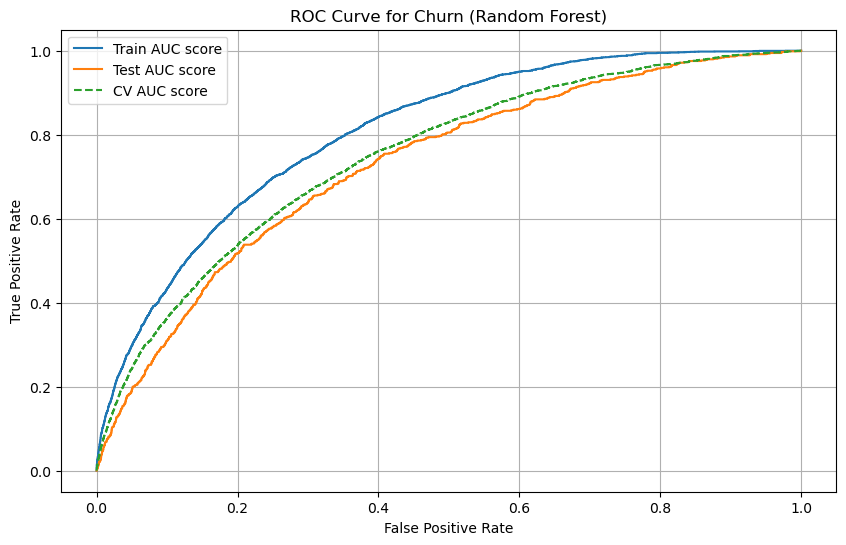

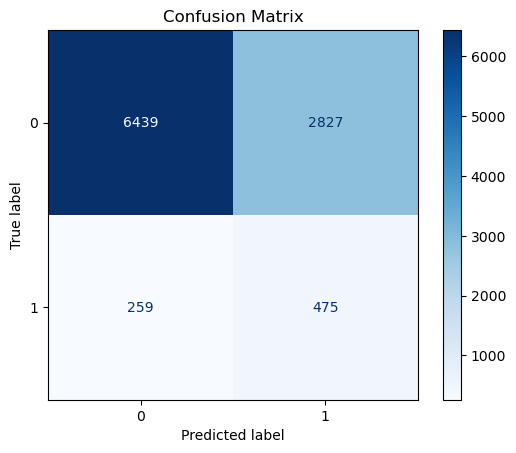

In [ ]:
model = xgb.XGBClassifier(random_state=9, scale_pos_weight= np.sum(y_train == 0) / np.sum(y_train == 1), max_depth=5, min_child_weight=5, 
                          gamma=1, subsample=0.6, colsample_bytree=0.6, learning_rate=0.05, n_estimators=50)
roc_auc, roc_auc_cv_mean, cm = evaluate_model(model, X_train, y_train, X_test, y_test)

#### Feature Selection

In [ ]:
model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.6, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=1, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=5, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=50, n_jobs=None,
              num_parallel_tree=None, random_state=9, ...)

In [ ]:
# Feature selection
selector = SelectFromModel(model, threshold="median", prefit=True)
selector.fit(X_train)
X_train_selected = X_train[X_train.columns[selector.get_support()]]
X_test_selected  = X_test[X_test.columns[selector.get_support()]]
X_train_selected.to_csv('../data/interim/X_train_selected.csv')
X_test_selected.to_csv('../data/interim/X_test_selected.csv')

model ROC-AUC score on test set: 0.7288582794559348
              precision    recall  f1-score   support

           0       0.96      0.70      0.81      9266
           1       0.15      0.65      0.24       734

    accuracy                           0.70     10000
   macro avg       0.55      0.68      0.52     10000
weighted avg       0.90      0.70      0.77     10000

Cross-validated ROC-AUC scores: [0.75201238 0.77208832 0.76971431 0.7461324  0.74459141 0.73560617
 0.77258151 0.73156602 0.78116935 0.71605569]
Mean Cross-validated ROC-AUC score: 0.7521517557198079


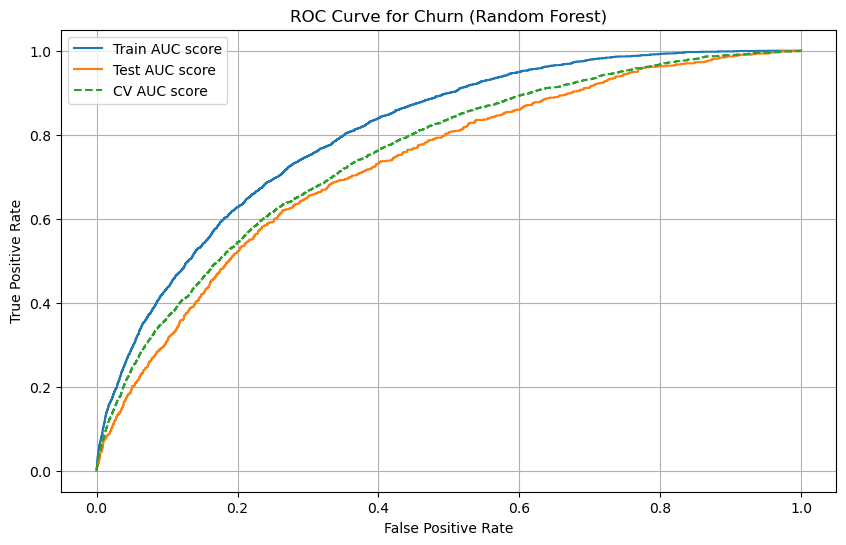

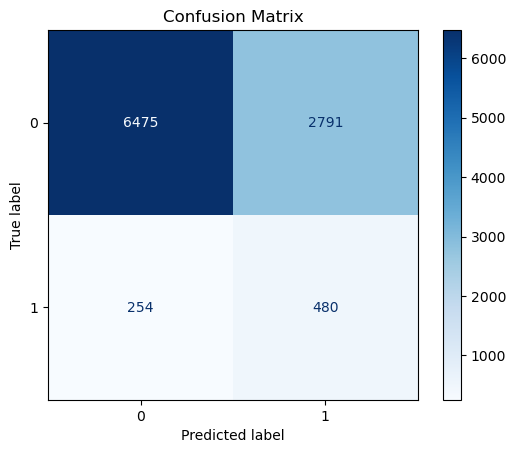

In [ ]:
roc_auc, roc_auc_cv_mean, cm = evaluate_model(model, X_train_selected, y_train, X_test_selected, y_test)

#### Hyperparameter Tuning

In [ ]:
param_grid = {
    'max_depth': [3, 5, 7],
    'min_child_weight': [1, 5, 10],
    'gamma': [0, 1, 5],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [20, 30, 50]
}

In [ ]:
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=9)

# Perform grid search
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, scoring='roc_auc', n_jobs=-1, cv=cv, verbose=2)
grid_search.fit(X_train_selected, y_train)

# Best parameters and model
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

Fitting 10 folds for each of 2187 candidates, totalling 21870 fits
[CV] END colsample_bytree=0.6, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=20, subsample=0.6; total time=   0.2s
[CV] END colsample_bytree=0.6, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=20, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=0.6, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=20, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=0.6, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=30, subsample=0.6; total time=   0.2s
[CV] END colsample_bytree=0.6, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=30, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=0.6, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=30, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=0.6, gamma=0, learning_rate=0.01, max_depth

In [ ]:
print("Best parameters found: ", best_params)

Best parameters found:  {'colsample_bytree': 0.8, 'gamma': 5, 'learning_rate': 0.1, 'max_depth': 5, 'min_child_weight': 10, 'n_estimators': 50, 'subsample': 0.6}


model ROC-AUC score on test set: 0.7293539975922052
              precision    recall  f1-score   support

           0       0.96      0.70      0.81      9266
           1       0.15      0.65      0.24       734

    accuracy                           0.70     10000
   macro avg       0.55      0.68      0.53     10000
weighted avg       0.90      0.70      0.77     10000

Cross-validated ROC-AUC scores: [0.75305367 0.77107511 0.77418857 0.75023129 0.74007722 0.74142042
 0.76963721 0.73304735 0.78220279 0.72594726]
Mean Cross-validated ROC-AUC score: 0.75408808950468


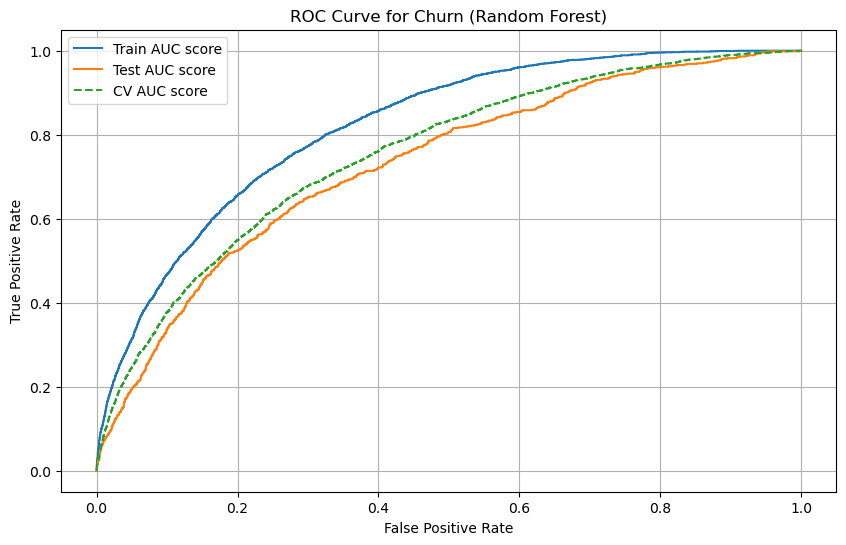

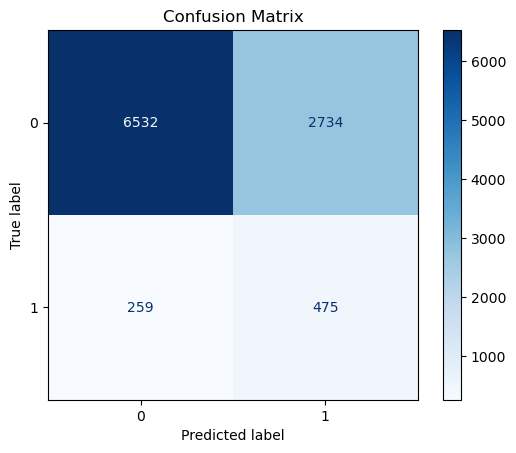

In [ ]:
roc_auc, roc_auc_cv_mean, cm = evaluate_model(best_model, X_train_selected, y_train, X_test_selected, y_test)

- this models seems to perform the best amongst all, we can continue with this

### Deploying the final model

- Training model onn complete data and deploying

In [ ]:
# Combine training and test sets for final training
X_full = pd.concat([X_train_selected, X_test_selected])
y_full = np.concatenate([y_train, y_test])

In [ ]:
final_model = xgb.XGBClassifier(random_state=9, scale_pos_weight= np.sum(y_train == 0) / np.sum(y_train == 1), max_depth=5, min_child_weight=10, 
                          gamma=1, subsample=0.6, colsample_bytree=0.6, learning_rate=0.1, n_estimators=50)

In [ ]:
final_model.fit(X_full, y_full)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.6, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=1, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=10, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=50, n_jobs=None,
              num_parallel_tree=None, random_state=9, ...)

#### Save the trained model, encoders, imputers, and mappings

- for mantaing consistency we have to store our encodings,and mappings soit can be applied to the new data set.

In [ ]:
joblib.dump(final_model, '../models/final_xgb_model.pkl')
joblib.dump(selector, '../models/metadata/feature_selector.pkl')
joblib.dump(woe_encoder, '../models/metadata/woe_encoder.pkl')
joblib.dump(ordinal_encoder, '../models/metadata/ordinal_encoder.pkl')
joblib.dump(imp, '../models/metadata/imputer.pkl')
joblib.dump(category_mappings, '../models/metadata/category_mappings.pkl')
joblib.dump(ohe_mapping, '../models/metadata/ohe_mapping.pkl')
joblib.dump(na_flags, '../models/metadata/na_flags.pkl')

print("Final model, feature selector, WOE encoder, ordinal encoder, imputer, category mappings, and OHE mappings saved successfully!")

Final model, feature selector, WOE encoder, ordinal encoder, imputer, category mappings, and OHE mappings saved successfully!


#### Unit Test before deploying

- Unit test for preprocessing data pipeline

In [ ]:
class TestPreprocessing(unittest.TestCase):
    def setUp(self):
        self.temp_data = pd.read_csv('../data/processed/preprocessed.csv')
    
    def test_category_mapping(self):
        category_mappings = create_category_mapping(self.temp_data, threshold=0.8)
        self.assertIsInstance(category_mappings, dict)
        self.assertTrue(all(isinstance(categories, list) for categories in category_mappings.values()))
    
    def test_apply_category_mapping(self):
        category_mappings = create_category_mapping(self.temp_data, threshold=0.8)
        mapped_data = apply_category_mapping(self.temp_data, category_mappings)
        for column, categories in category_mappings.items():
            self.assertTrue(mapped_data[column].isin(categories + ['Others']).all())
    
    def test_encode_low_cardinality(self):
        encoded_data, ohe_mapping = encode_low_cardinality(self.temp_data)
        self.assertIsInstance(encoded_data, pd.DataFrame)
        self.assertIsInstance(ohe_mapping, dict)
    
    def test_flag_numeric(self):
        flagged_data, na_flags = flag_numeric(self.temp_data)
        self.assertIsInstance(flagged_data, pd.DataFrame)
        self.assertIsInstance(na_flags, list)
        for flag in na_flags:
            self.assertIn(flag, flagged_data.columns)

In [ ]:
unittest.main(argv=[''], exit=False)

../Users/luv/miniconda3/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/luv/miniconda3/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/luv/miniconda3/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/luv/miniconda3/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.

#### fitting model to new data

- Function to predict new data.

In [ ]:
# Load the trained model and preprocessing objects
final_model = joblib.load('../models/final_xgb_model.pkl')
preprocessed_col = joblib.load('../data/processed/preprocessed_columns.pkl')
ordinal_encoder = joblib.load('../models/metadata/ordinal_encoder.pkl')
category_mappings = joblib.load('../models/metadata/category_mappings.pkl')
ohe_mapping = joblib.load('../models/metadata/ohe_mapping.pkl')
na_flags = joblib.load('../models/metadata/na_flags.pkl')
woe_encoder = joblib.load('../models/metadata/woe_encoder.pkl')
imp = joblib.load('../models/metadata/imputer.pkl')
selector = joblib.load('../models/metadata/feature_selector.pkl')
duplicate_mapping_dropped = joblib.load('../models/metadata/dropped_duplicate_mapping.pkl')


def preprocess_new_data(new_data):
    #preprocess new data
    new_data=new_data[preprocessed_col.drop(['is_churn'])]
    
    # Guardrail 1: Check if required columns are present
    required_columns = set(category_mappings.keys()).union({'Var73'}).union(new_data.select_dtypes(include='O').columns)
    missing_columns = required_columns - set(new_data.columns)
    if missing_columns:
        raise ValueError(f"Missing required columns: {missing_columns}")

  # Apply the same preprocessing steps to the new data
    bins = [0, 25, 50, 75, 100, 125, 150, 175, 200, 225, 250, np.inf]
    labels = ['1-25', '26-50', '51-75', '76-100', '101-125', '126-150', '151-175', '176-200', '201-225', '226-250', '251+']
    new_data = bin_variable(new_data, 'Var73', bins, labels)
    new_data['Var73'] = ordinal_encoder.transform(new_data[['Var73']])
    new_data = apply_category_mapping(new_data, category_mappings)

    # One-hot encoding using the saved mappings
    for column, encoder in ohe_mapping.items():
        one_hot_encoded = encoder.transform(new_data[[column]])
        one_hot_encoded_df = pd.DataFrame(one_hot_encoded, columns=encoder.get_feature_names_out([column]))
        new_data = pd.concat([new_data, one_hot_encoded_df], axis=1)
        new_data.drop(column, axis=1, inplace=True)

    new_data.select_dtypes(include='O').fillna('Unknown', inplace=True)

    # Add NA flags
    for flag in na_flags:
        column_name = flag.replace('_na', '')
        new_data[flag] = new_data[column_name].isna()

    # Drop duplicate mapping columns only
    new_data = new_data[duplicate_mapping_dropped.drop(['is_churn'])]

    # Encode with WOE
    new_data_encoded = new_data.copy()
    new_data_encoded[new_data.select_dtypes('O').columns] = woe_encoder.transform(new_data.select_dtypes('O'))

    # Impute missing values
    new_data_imputed = new_data_encoded.copy()
    new_data_imputed.loc[:, new_data_encoded.columns] = imp.transform(new_data_encoded)

    # Feature selection
    new_data_selected = new_data_imputed[new_data_imputed.columns[selector.get_support()]]
    
    return new_data_selected


In [ ]:
#new_data = Enter path to new data

#### Making predictions in new data

In [ ]:
new_data_preprocessed = preprocess_new_data(new_data)
predictions = final_model.predict(new_data_preprocessed)
probabilities = final_model.predict_proba(new_data_preprocessed)[:, 1]

## Model Limitations and Further Explorations

- The model might still be biased towards the majority class despite handling techniques. We may need to perform more granular analysis, for example we can look at how models perform for different categories of the categorical variables
- Outliers could be treated with domain knowledge evaluating their impact on business
- Better offline/online metrics can be made
- Missingness may need to be further explored using better statiscal test and may provide better results if we properly figure them out.
- imputations techniques like mice can be further explored to provide more accurate imputations.ie- using knn, instead of default regression, using a different strategy etc.
- Preprocessing steps may require re-evaluation with data distribution changes.
- Ensemble models require complex model agnostic methods to understand and as the data is encrypted therefore getting meaningful inference may be difficult.
- XGBoost can be computationally intensive as data scales.
- Interaction usin ICE-plots, h statistics, shap could also be explored for feature engineering
- Creating new features based on properties mean/stddev of numerical features or based on binning based on other threshold etc can be explored.
- Experiments can be performed with other models.